In [93]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from os.path import join
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn.functional as F
from torch import nn, cuda
from torch.utils.data import Dataset,TensorDataset, DataLoader, SubsetRandomSampler
import pickle
from torchsampler import ImbalancedDatasetSampler
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report
from tqdm.notebook import tqdm

In [78]:
class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        #column_names_fill = ["mjd", "mag", "err", "phase", "real"]
        self.folder = folder_name
        self.mag_inter = torch.empty(100)
        self.label = torch.empty(1)
        #self.classes = ["T2C", "ECL"]
        #df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            mag_std = rrl_data["mag"].std()
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/mag_std
            rrl_data["err"] = rrl_data["err"]/mag_std
            # Interpolacion
            # ventaneo Gaussiano
            window = lambda phi_point : np.exp(-0.5*(phi_point-rrl_data["phase"])**2/0.03**2)
            # espaciado regular de 100 pts entre 0 y 1
            phi_interp = np.linspace(0, 1, num=100)
            # cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
            rrl_data["mag"] = np.array([np.sum(window(phi_val)*rrl_data["mag"])/np.sum(window(phi_val)) for phi_val in phi_interp])
            rrl_data.sort_values(by="phase", inplace=True)
            # orden cols: ['mjd','mag','err','phase']
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.data)


In [12]:
with open("best50_10each_notInterpol.pkl", "rb") as f:
    lc = pickle.load(f)

In [79]:
with open('ecl_c.pkl', 'rb') as handle:
    vvv_ecl_c = pickle.load(handle)
#label 0

In [80]:
with open('ecl_nc.pkl', 'rb') as handle:
    vvv_ecl_nc = pickle.load(handle)
#label 1

In [81]:
with open('ell.pkl', 'rb') as handle:
    vvv_ell = pickle.load(handle)
#label 2

In [82]:
with open('rrab.pkl', 'rb') as handle:
    vvv_rrab = pickle.load(handle)
#label 3

In [83]:
with open('rrc.pkl', 'rb') as handle:
    vvv_rrc = pickle.load(handle)
#label 4

In [84]:
#dataset
VVV = torch.utils.data.ConcatDataset([vvv_ecl_c, vvv_ecl_nc, vvv_ell,vvv_rrab, vvv_rrc])

In [124]:
VVV[420]['data'].shape

torch.Size([100])

In [13]:
#VVV[lc num 0-67102]['data' o 'label']

In [89]:
test_set_indices=list()
c1,c2,c3,c4,c5= 0,0,0,0,0
for i in range(len(VVV)):
    if c1<250:
        if VVV[i].__getitem__('label').item()== 0:
            test_set_indices.append(i)
            c1+=1
    elif c2<250:
        if VVV[i].__getitem__('label').item()== 1:
            test_set_indices.append(i)
            c2+=1
    elif c3<250:
        if VVV[i].__getitem__('label').item()== 2:
            test_set_indices.append(i)
            c3+=1
    elif c4<250:
        if VVV[i].__getitem__('label').item()== 3:
            test_set_indices.append(i)
            c4+=1
    elif c5<250:
        if VVV[i].__getitem__('label').item()== 4:
            test_set_indices.append(i)
            c5+=1
display(len(test_set_indices))   

1250

In [265]:

VVV.__len__()*0.8

53682.4

In [274]:
# splitear Train y Test sets random ~75/25 = 50328/16775, ~80/20 = 53683/13420
whole_indices = np.arange(VVV.__len__())
np.random.shuffle(whole_indices)
random_test_set = set(whole_indices[:13420])
#display(random_test_set)
whole_indices = set(whole_indices)
train_set_randind = whole_indices - random_test_set
train_set = list(train_set_randind)
test_set = list(random_test_set)
display(train_set.__len__(),test_set.__len__())

53683

13420

In [275]:
test_set_indices = set(test_set_indices)
whole_set_indices = set(range(len(VVV)))

train_set_indices = whole_set_indices - test_set_indices
train_set = list(train_set_indices)
test_set = list(test_set_indices)

In [287]:
# sin IbalancedDatasetSampler 
train_loader = DataLoader(VVV,
    sampler=SubsetRandomSampler(train_set),
    batch_size=64, shuffle=False)

In [288]:
test_loader = DataLoader(VVV,
    sampler=SubsetRandomSampler(test_set),
    batch_size=32, shuffle=False)

In [94]:
# ImbalancedDatasetSampler
train_loader = DataLoader(VVV,
    sampler=ImbalancedDatasetSampler(VVV, indices=train_set, callback_get_label= lambda dataset, idx:dataset.__getitem__(idx)['label'].item()),
    batch_size=128, shuffle=False)

<IPython.core.display.Javascript object>


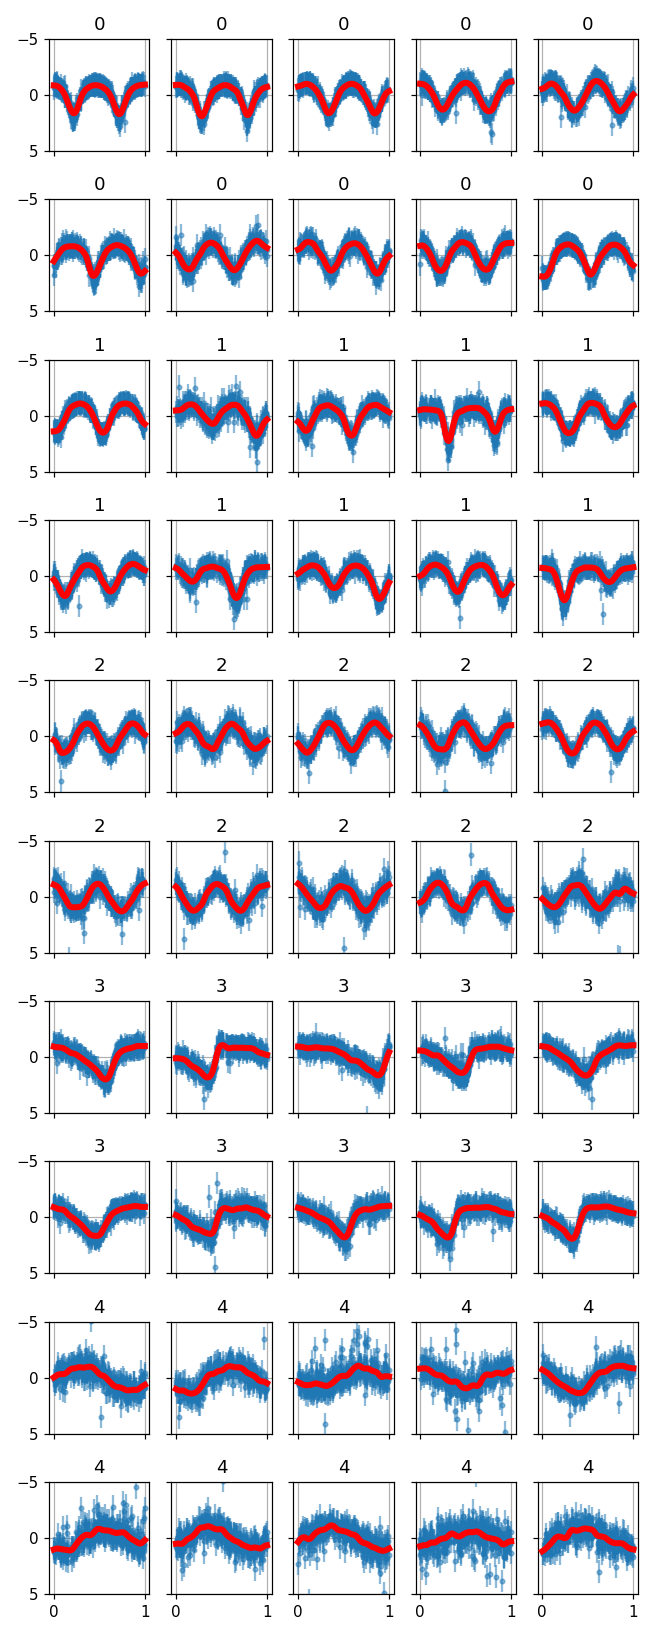

In [20]:
fig, ax = plt.subplots(10, 5, tight_layout=True, figsize=(6, 15), 
                       sharex=True, sharey=True)
ax[0, 0].invert_yaxis()
ax[0, 0].set_ylim([5, -5])
window = lambda phi_point, phi : np.exp(-0.5*(phi_point-phi)**2/0.03**2)
phi_interp = np.linspace(0, 1, num=100)

data = []
labels = []
for i, ax_ in enumerate(ax.ravel()):
    phi, mag, err = lc[i]['data'].detach().numpy()
    mask = ~(mag == 0.0)
    phi = phi[mask]
    mag = mag[mask]
    err = err[mask]
    ax_.errorbar(phi, mag, err, fmt='.', alpha=0.5)
    mag_interp = np.array([np.sum(window(p, phi)*mag)/np.sum(window(p, phi)) for p in phi_interp])
    data.append(mag_interp)
    labels.append(lc[i]['label'].item())
    ax_.plot(phi_interp, mag_interp, 'r-', lw=4, zorder=100)
    ax_.grid()
    ax_.set_title(lc[i]['label'].item())

In [46]:
data_torch = TensorDataset(torch.from_numpy(np.array(data).astype('float32')),
                           torch.from_numpy(np.array(labels).astype('int64')))
loader = DataLoader(data_torch, batch_size=5,shuffle=True)

In [23]:
class Example(torch.nn.Module):
    def __init__(self, n_channels=32, n_linear=8):
        super(Example, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=n_channels, stride=2, kernel_size=3)
        self.conv2 = torch.nn.Conv1d(in_channels=n_channels, out_channels=n_channels, stride=2, kernel_size=3)
        self.conv3 = torch.nn.Conv1d(in_channels=n_channels, out_channels=n_channels, stride=2, kernel_size=3)
        self.gpool = torch.nn.AvgPool1d(kernel_size=11)
        self.linear1 = torch.nn.Linear(in_features=n_channels, out_features=n_linear)
        self.linear2 = torch.nn.Linear(in_features=n_linear, out_features=5)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        h = self.activation(self.conv1(x))
        h = self.activation(self.conv2(h))
        h = self.activation(self.conv3(h))
        #print(h.shape)
        h = self.gpool(h)
        h = h.view(-1, 32)
        h = self.activation(self.linear1(h))
        return self.linear2(h)

In [289]:
model = Example()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
#criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
criterion = torch.nn.CrossEntropyLoss()


In [290]:
epochs = range(500)
TL,VL=[],[]
use_gpu = True
best_valid = np.inf
ultima_mejora = 0

In [291]:

if use_gpu:
    model = model.cuda()

for epoch in tqdm(epochs):
    if epoch-ultima_mejora >=50:
        print("Hace al menos 50 épocas NO estoy generalizando correctamente :/ \n fix me!")
        break
    train_loss, valid_loss = 0.0,0.0
    # TRAINING
    for data in train_loader:
        x,y = data['data'].unsqueeze(-1),data['label']
        x = x.transpose(1,2)
        if use_gpu:
            x,y=x.cuda(),y.cuda()
        optimizer.zero_grad()
        haty = model.forward(x)
        #print(haty.shape,y.shape)
        loss = criterion(haty, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    TL.append(train_loss/train_loader.__len__())
    
    # VALIDATION
    for data in test_loader:
        x,y = data['data'].unsqueeze(-1), data['label']
        x = x.transpose(1,2)
        if use_gpu:
            x,y = x.cuda(),y.cuda()
        haty = model.forward(x)
        loss = criterion(haty,y)
        valid_loss += loss.item()
        if valid_loss < best_valid:
            ultima_mejora = epoch+1
            print("vamos mejorando :) epoch=",epoch+1)
            best_valid = valid_loss
            torch.save({'epoca': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, '/home/amorales/models/best_LC-Clas.pt')
    VL.append(valid_loss/test_loader.__len__())
    
if use_gpu:
    model = model.cpu()


vamos mejorando :) epoch= 1
vamos mejorando :) epoch= 3
vamos mejorando :) epoch= 4
vamos mejorando :) epoch= 7
vamos mejorando :) epoch= 48
Hace al menos 50 épocas NO estoy generalizando correctamente :/ 
 fix me!


<IPython.core.display.Javascript object>


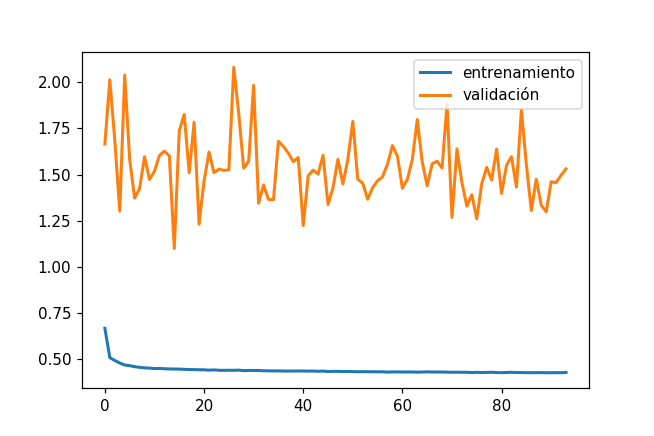

In [286]:
#plt.figure()
#plt.plot(range(len(TL)),TL,'r-',range(len(VL)),VL,'g-')
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(range(len(TL)), TL, lw=2, label='entrenamiento')
ax.plot(range(len(VL)), VL, lw=2, label='validación')
#ax.set_ylim([0.0, 1.05])
plt.legend()
plt.show()

In [292]:
y_true = [VVV[i]['label'].item() for i in test_set]
prediction_test = []
for data in test_loader:
    x,y = data['data'].unsqueeze(-1),data['label']
    x = x.transpose(1,2)
    outputs = model.forward(x)
    prediction_test.append(outputs.detach().argmax(dim=1).numpy())

y_pred = np.concatenate(prediction_test)

#display(y_true,y_pred)

cm = confusion_matrix(y_true, y_pred)
display(cm)

print(classification_report(y_true, y_pred))

array([[ 87,  70,   0,  92,   1],
       [ 68,  69,   0, 113,   0],
       [ 78,  69,   0, 103,   0],
       [ 74,  88,   0,  88,   0],
       [ 78,  75,   0,  97,   0]])

              precision    recall  f1-score   support

           0       0.23      0.35      0.27       250
           1       0.19      0.28      0.22       250
           2       0.00      0.00      0.00       250
           3       0.18      0.35      0.24       250
           4       0.00      0.00      0.00       250

    accuracy                           0.20      1250
   macro avg       0.12      0.20      0.15      1250
weighted avg       0.12      0.20      0.15      1250



/home/amorales/.conda/envs/astro/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [138]:
outputs = model.forward(data_torch.tensors[0].unsqueeze(1))
#print(outputs.detach().squeeze(1).shape)
y_pred = outputs.detach().argmax(dim=1).numpy()
y_true = data_torch.tensors[1]
#print(y_pred,y_true)
#result = torch.nn.Sigmoid() (outputs).detach().squeeze(1)
#result = np.argmax((model.forward(data_torch.tensors[0].unsqueeze(1))).detach().squeeze(1))

display(y_true,y_pred)
cm = confusion_matrix(y_true, y_pred)
display(cm)

print(classification_report(y_true, y_pred))
#display(result,)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3])

array([[10,  0,  0,  0,  0],
       [ 5,  5,  0,  0,  0],
       [ 0,  0, 10,  0,  0],
       [ 0,  0,  0, 10,  0],
       [ 0,  0,  0,  1,  9]])

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.50      0.67        10
           2       1.00      1.00      1.00        10
           3       0.91      1.00      0.95        10
           4       1.00      0.90      0.95        10

    accuracy                           0.88        50
   macro avg       0.92      0.88      0.87        50
weighted avg       0.92      0.88      0.87        50

